#### 如何使用pytorch框架实现一个mnist手写数字识别的简单的强化学习demo？

实现一个简单的基于PyTorch的强化学习（RL）Demo来解决MNIST手写数字识别问题是不太常见的，因为通常RL更适用于连续动作和状态空间的问题，而不是像MNIST这样的离散分类问题。然而，你可以将这个问题转换成一个RL问题，例如，你可以尝试使用深度强化学习算法，如DQN，来训练一个代理（agent）来处理MNIST数据。

下面是一个简单的示例代码，演示如何使用PyTorch和DQN来解决MNIST手写数字识别问题：

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import random
import numpy as np

# 定义简单的DQN网络
# DQN的目标是学习到一个在给定状态下，选择最优动作的策略，从而使智能体能够在环境中获取最大的累积奖励。
class DQN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()
        self.fc = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, output_size)

    def forward(self, x):
        x = torch.relu(self.fc(x))
        x = self.fc2(x)
        return x

# 定义经验回放缓冲区
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []

    def push(self, transition):
        self.buffer.append(transition)
        if len(self.buffer) > self.capacity:
            del self.buffer[0]

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

# 定义一个简单的环境，将MNIST数据集作为状态空间
class MNISTEnvironment:
    def __init__(self):
        self.dataset = MNIST(root='/data/mwj/data', train=True, download=False,
                              transform=transforms.Compose([transforms.ToTensor()]))
        self.dataloader = DataLoader(self.dataset, batch_size=1, shuffle=True)
        self.current_state = None
        self.action_space = [i for i in range(10)]

    def reset(self):
        image, label = next(iter(self.dataloader))
        self.current_state = image.view(-1).numpy()
        return self.current_state

    def step(self, action):
        reward = 0
        done = False
        try:
            next_image, label = next(iter(self.dataloader))
            next_state = next_image.view(-1).numpy()
        except StopIteration:
            done = True
            next_state = self.current_state
        if action == label:
            reward = 1
        return next_state, reward, done

# 定义DQN的训练过程
def train_dqn(env, model, target_model, optimizer, buffer, gamma, batch_size, num_episodes, target_update_freq):
    criterion = nn.MSELoss()
    total_steps = 0  # 记录总的训练步数
    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0
        done = False
        while not done:
            epsilon = 0.1
            if random.random() < epsilon:
                action = random.choice(env.action_space)
            else:
                with torch.no_grad():
                    q_values = model(torch.tensor(state, dtype=torch.float32).to(device))
                    action = torch.argmax(q_values).item()

            next_state, reward, done = env.step(action)
            total_reward += reward

            buffer.push((state, action, reward, next_state, done))

            state = next_state

            if len(buffer) > batch_size:
                transitions = buffer.sample(batch_size)
                batch_state, batch_action, batch_reward, batch_next_state, batch_done = zip(*transitions)

                batch_state = torch.tensor(batch_state, dtype=torch.float32).to(device)
                batch_action = torch.tensor(batch_action, dtype=torch.long).to(device)
                batch_reward = torch.tensor(batch_reward, dtype=torch.float32).to(device)
                batch_next_state = torch.tensor(batch_next_state, dtype=torch.float32).to(device)
                batch_done = torch.tensor(batch_done, dtype=torch.float32).to(device)

                q_values = model(batch_state.to(device))
                next_q_values = target_model(batch_next_state.to(device)).max(dim=1)[0]
                target_values = batch_reward + (1 - batch_done) * gamma * next_q_values

                target_q_values = q_values.clone().detach()
                target_q_values[range(batch_size), batch_action] = target_values

                loss = criterion(q_values, target_q_values)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # 软更新目标网络
                if total_steps % target_update_freq == 0:
                    soft_update(target_model, model, tau=0.01)  # 设置软更新参数 tau
            
                # print(f"loss: {loss.item()}")
            total_steps += 1  # 更新总的训练步数

        print("Episode {}: Total Reward = {}".format(episode, total_reward))

def soft_update(target_model, model, tau):
    for target_param, param in zip(target_model.parameters(), model.parameters()):
        target_param.data.copy_(tau * param.data + (1.0 - tau) * target_param.data)


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# 创建环境和模型
env = MNISTEnvironment()
input_size = 28 * 28
output_size = 10
model = DQN(input_size, output_size).to(device)
target_model = DQN(input_size, output_size).to(device)
target_model.load_state_dict(model.state_dict())
optimizer = optim.Adam(model.parameters(), lr=0.001)
buffer = ReplayBuffer(capacity=10000)
gamma = 0.99
batch_size = 32
num_episodes = 1


# 训练DQN模型
train_dqn(env, model, target_model, optimizer, buffer, gamma, batch_size, num_episodes, 20)


loss: 0.012562339194118977
loss: 0.008099504746496677
loss: 0.005411564838141203
loss: 0.004174706991761923
loss: 0.0034522463101893663
loss: 0.002754356013610959
loss: 0.002635128563269973
loss: 0.0029291007667779922
loss: 0.005342904012650251
loss: 0.005789635237306356
loss: 0.004471152555197477
loss: 0.006033007055521011
loss: 0.004363666754215956
loss: 0.004042037297040224
loss: 0.006107087712734938
loss: 0.005817280150949955
loss: 0.004700637888163328
loss: 0.0019112963927909732
loss: 0.0033415004145354033
loss: 0.002527732402086258
loss: 0.0015616053715348244
loss: 0.004957437515258789
loss: 0.0041802204214036465
loss: 0.003533989191055298
loss: 0.00202165893279016
loss: 0.0035462421365082264
loss: 0.0010870522819459438
loss: 0.001648181350901723
loss: 0.002967839129269123
loss: 0.0006663869135081768
loss: 0.0022631410975009203
loss: 0.00031358475098386407
loss: 0.0013479801127687097
loss: 0.0032708204817026854
loss: 0.0029314581770449877
loss: 0.0011303186183795333
loss: 0.00253

KeyboardInterrupt: 

这个示例代码中，我们使用DQN来训练一个智能体（agent），通过观察MNIST数据集中的图像来学习识别手写数字。在这个示例中，MNIST数据集被作为状态空间，智能体通过观察图像并采取动作来尝试识别数字。


在训练完成后，可以通过评估模型在测试集上的性能来评估其效果。在MNIST手写数字识别问题中，你可以使用测试集的图像和标签来评估模型的准确率（accuracy）。下面是一个简单的示例代码，演示如何评估训练好的模型在测试集上的性能：

In [ ]:
def test_dqn(env, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in env.dataloader:
            images = images.view(-1).numpy()
            q_values = model(torch.tensor(images, dtype=torch.float32))
            action = torch.argmax(q_values).item()
            if action == labels:
                correct += 1
            total += 1
    accuracy = correct / total
    print("Test Accuracy: {:.2f}%".format(accuracy * 100))

# 调用测试函数进行模型评估
test_dqn(env, model)


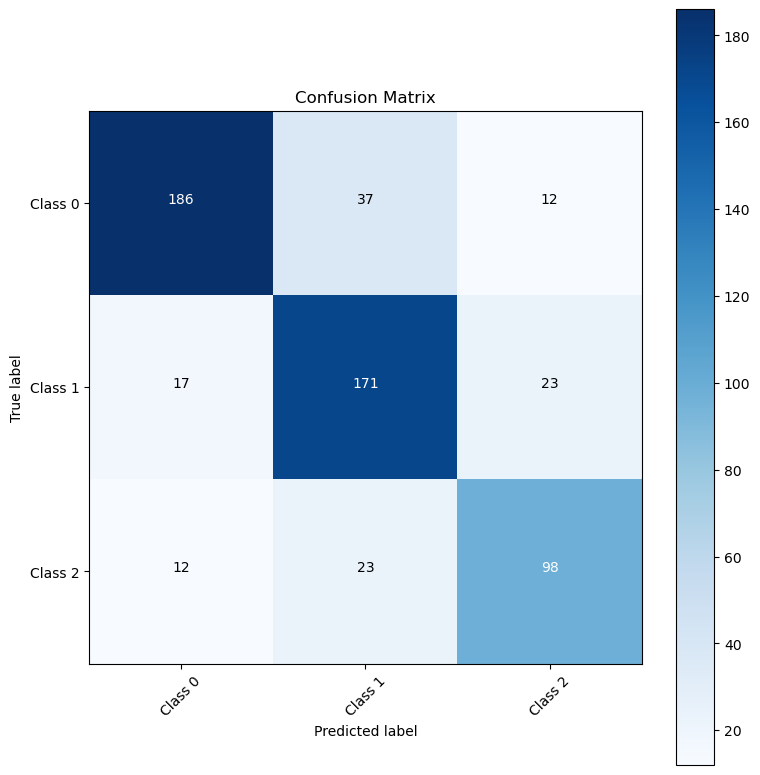

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

# 假设 y_true 和 y_pred 已定义
# cm = confusion_matrix(y_true, y_pred)
# 为了演示，创建一个示例混淆矩阵
cm = np.array([[186, 37, 12], [17, 171, 23], [12, 23, 98]])
labels_txt = ['Class 0', 'Class 1', 'Class 2']  # 示例标签

plt.figure(figsize=(8, 8))
tick_marks = np.arange(len(labels_txt))
plt.xticks(tick_marks, labels_txt, rotation=45)


# 1使用 'Blues' 颜色映射，Y轴从上到下是class0,class1,class2的顺序，不用加[::-1]逆序，但是不能保存为pdf，显示有斜条纹，但是png就可以
plt.imshow(cm, cmap='Blues', interpolation='nearest', aspect='equal')  # 添加 cmap 参数
plt.yticks(tick_marks, labels_txt)

# 2使用 pcolormesh 替代 imshow，这种会导致Y轴从上到下不是class0,class1,class2的顺序，解决方法：plt.yticks(tick_marks, labels_txt[::-1])增加那个[::-1]
# 强制将Y轴文字逆序，但是还有个问题，cm也会变成按照第二维度逆序的，所以也需要将cm也按照列逆序一下
# X, Y = np.meshgrid(np.arange(cm.shape[1]), np.arange(cm.shape[0]))
# cm = cm[::-1]
# plt.pcolormesh(X, Y, cm, cmap='Blues', linewidth=0.5) #edgecolors='k', 
# plt.yticks(tick_marks, labels_txt[::-1])


# 添加颜色条
plt.colorbar()

# 在单元格中添加数值，并动态设置文本颜色
thresh = cm.max() / 2  # 用于判断文本颜色的阈值
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(
        j,
        i,
        f"{cm[i, j]}",
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black",  # 动态设置颜色
    )

plt.title("Confusion Matrix")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
# plt.imshow，保存为png，使用pcolormesh，可以保存为pdf
plt.savefig("confusionmatrix2_.png")
plt.show()